In [226]:
import plotly.express as px
import plotly.graph_objects as go
#data imports
import pandas as pd
import numpy as np
import os
import pandas_datareader.data as web
from datetime import datetime
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='YOUR_API_KEY',output_format='pandas', indexing_type='date')

In [228]:
def adjust(date, close, adj_close, in_col, rounding=4):
    '''
    If using forex or Crypto - Change the rounding accordingly!
    '''
    try:
        factor = adj_close / close
        return round(in_col * factor, rounding)
    except ZeroDivisionError:
        print('WARNING: DIRTY DATA >> {} Close: {} | Adj Close {} | in_col: {}'.format(date, close, adj_close, in_col))
        return 0

    
def getTickerData(ticker, start,end):
    df, meta_data = ts.get_daily_adjusted(ticker, outputsize='full')    
    df.sort_index(ascending=True, inplace = True)
    
    df = df[start:end]
    
    df['adj close'] = df['5. adjusted close']
    df['adj open'] = np.vectorize(adjust)(df.index.date, df['4. close'], df['5. adjusted close'], df['1. open'])
    df['adj high'] = np.vectorize(adjust)(df.index.date, df['4. close'], df['5. adjusted close'], df['2. high'])
    df['adj low'] = np.vectorize(adjust)(df.index.date, df['4. close'], df['5. adjusted close'], df['3. low'])    
    #calculate daily returns
    df['daily_return'] = df['adj close'].pct_change()
    # calculate cumluative return
    df['cumluative_return'] = np.exp(np.log1p(df['daily_return']).cumsum())
    
    return df[['adj open','adj close','adj high', 'adj low', 'daily_return', 'cumluative_return'  ]]


def getPtf(tickers, start, end):
    
    ptf = pd.DataFrame()
       
    for stock in tickers:
        df = getTickerData(stock, start, end)
        df.sort_index(ascending=True, inplace = True)
        df = pd.concat({stock: df}, names=['stock'])
        ptf =  pd.concat([df, ptf], axis=0)
        
    return ptf


def getPtfColumns(tickers, start, end):
    
    ptf = pd.DataFrame()
       
    for stock in tickers:
        df = getTickerData(stock, start, end)
        df.sort_index(ascending=True, inplace = True)
        df.columns = pd.MultiIndex.from_product([[stock], df.columns])
        ptf =  pd.concat([df, ptf], axis=1)
        
    return ptf

def getSpecificColumns(ptf, column, stocks):
    new_ptf = pd.DataFrame()

    for each in stocks:
        df = ptf.loc[:, each][[column]]
        df.columns = [each]
        new_ptf = pd.concat([df, new_ptf], axis=1)
    return new_ptf

def ptfPerformance(weights, ptf):
    returns = getSpecificColumns(ptf, 'daily_return', stocks)
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    weights_a = np.array(weights)
    
    ptf_return = np.sum(mean_returns*weights_a)*252
    
    ptf_std = np.sqrt(np.dot(weights_a.T, np.dot(cov_matrix, weights_a ))) * np.sqrt(252)
    
    return ptf_return, ptf_std

def stockPerformanceAnnualised(stock_daily_return):
    
    return np.mean(stock_daily_return)*252, np.std(stock_daily_return)*np.sqrt(252)


def randomWeights(n):
    k = np.random.rand(n)
    return k/sum(k)

def retrurnsAndStd(ptf, stocks, iterations):
    df = pd.DataFrame(columns = ['return', 'std'])
    for i in range(iterations):
        df.loc[i] = list(ptfPerformance(randomWeights(len(stocks)), ptf))
    return df

In [229]:
stocks = ['BABA','NIO','SPOT', 'DIS', 'JPM']

In [5]:
#ptf = getPtf(stocks, '2020-01-01','2021-01-01')

In [230]:
ptf = getPtfColumns(stocks, '2020-01-01','2021-01-01')

In [231]:
ptf

JPM                                               \
            adj open   adj close  adj high   adj low daily_return   
date                                                                
2020-01-02  133.9084  135.153730  135.1633  133.4007          NaN   
2020-01-03  132.5717  133.381568  134.2397  132.1667    -0.013112   
2020-01-06  131.6654  133.275511  133.3141  131.6075    -0.000795   
2020-01-07  132.3596  131.009740  132.9188  130.9519    -0.017001   
2020-01-08  130.8362  132.031747  132.6488  130.7398     0.007801   
...              ...         ...       ...       ...          ...   
2020-12-24  124.2004  123.634437  124.6571  122.6912    -0.004398   
2020-12-28  124.9252  124.448605  125.7493  123.9011     0.006585   
2020-12-29  125.3025  124.120952  125.3818  124.0018    -0.002633   
2020-12-30  124.5975  124.468463  124.9500  124.0117     0.002800   
2020-12-31  124.2004  126.166302  126.4245  123.9323     0.013641   

                                  DIS                                ...  \
           cumluative_return adj open adj close  adj high   adj low  ...   
date                                                                 ...   
2020-01-02               NaN   145.29    148.20  148.2000  145.1000  ...   
2020-01-03          0.986888   146.40    146.50  147.9000  146.0549  ...   
2020-01-06          0.986103   145.54    145.65  146.0300  144.3100  ...   
2020-01-07          0.969339   145.99    145.70  146.8699  145.4200  ...   
2020-01-08          0.976901   145.49    145.40  146.1300  144.8200  ...   
...                      ...      ...       ...       ...       ...  ...   
2020-12-24          0.914769   173.99    173.73  174.5799  172.3800  ...   
2020-12-28          0.920793   175.75    178.86  179.9200  175.0500  ...   
2020-12-29          0.918369   180.01    177.30  180.2000  176.2200  ...   
2020-12-30          0.920940   178.50    181.17  183.4000  178.3700  ...   
2020-12-31          0.933502   181.22    181.18  183.4000  180.2700  ...   

                NIO                                              BABA  \
           adj high  adj low daily_return cumluative_return  adj open   
date                                                                    
2020-01-02   4.1000   3.6100          NaN               NaN  216.6000   
2020-01-03   3.9000   3.4800     0.029570          1.029570  216.3500   
2020-01-06   4.2400   3.6600    -0.039164          0.989247  214.8900   
2020-01-07   3.7300   3.2100    -0.119565          0.870968  217.6400   
2020-01-08   3.4900   3.1300     0.046296          0.911290  216.6000   
...             ...      ...          ...               ...       ...   
2020-12-24  47.1299  45.3500    -0.026377         12.303763  228.2350   
2020-12-28  46.8500  43.6700    -0.037361         11.844086  216.8800   
2020-12-29  46.2750  42.2262     0.047208         12.403226  231.7600   
2020-12-30  48.3800  45.7200     0.048548         13.005376  243.3484   
2020-12-31  50.5000  47.7700     0.007441         13.102151  237.4600   

                                                                         
           adj close  adj high   adj low daily_return cumluative_return  
date                                                                     
2020-01-02    219.77  219.9800  216.5400          NaN               NaN  
2020-01-03    217.00  218.2025  216.0100    -0.012604          0.987396  
2020-01-06    216.64  217.1600  214.0900    -0.001659          0.985758  
2020-01-07    217.63  218.9400  216.6900     0.004570          0.990263  
2020-01-08    218.00  220.6500  216.3200     0.001700          0.991946  
...              ...       ...       ...          ...               ...  
2020-12-24    222.00  229.9000  211.2300    -0.133422          1.010147  
2020-12-28    222.36  224.9900  215.3201     0.001622          1.011785  
2020-12-29    236.26  239.1900  229.6000     0.062511          1.075033  
2020-12-30    238.39  243.3900  234.6452     0.009015          1.084725  


In [232]:
returns = getSpecificColumns(ptf, 'daily_return', stocks)

In [233]:
cum_returns = getSpecificColumns(ptf, 'cumluative_return', stocks)

<AxesSubplot:xlabel='date'>

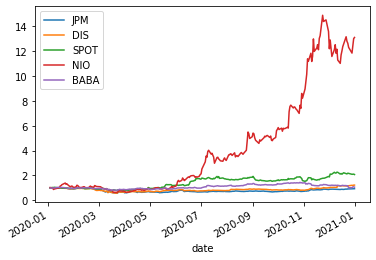

In [234]:
cum_returns.plot()

<AxesSubplot:xlabel='date'>

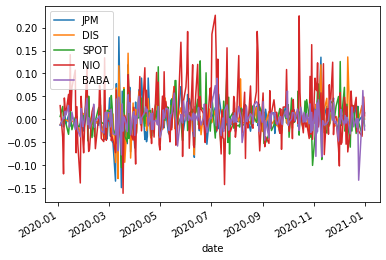

In [235]:
returns.plot()

In [236]:
df = retrurnsAndStd(ptf,stocks, 10000)

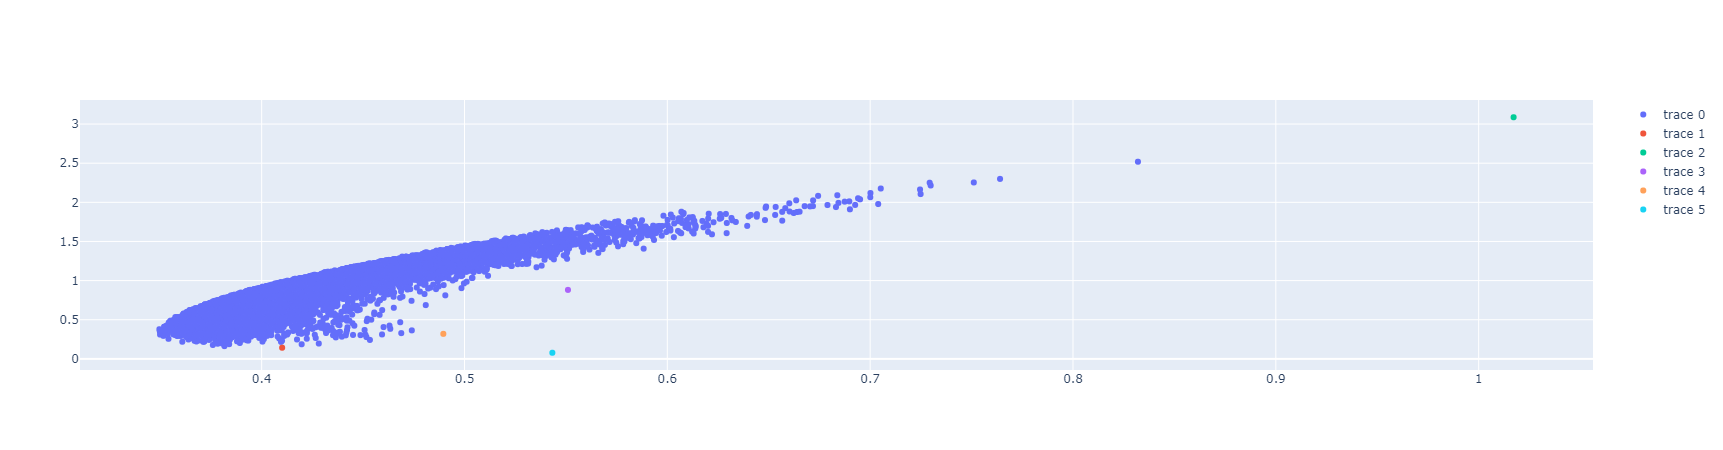

In [237]:
fig = go.Figure([
    go.Scatter(
        x=df['std'],
        y=df['return'],
        mode='markers'
    )
])


for each in stocks:

    fig.add_trace(go.Scatter(
            x=np.array(stockPerformanceAnnualised(ptf[each]['daily_return'])[1]),
            y=np.array(stockPerformanceAnnualised(ptf[each]['daily_return'])[0]),
            mode='markers',
            text = each))

fig.show()